In [1]:
# python env: modnenv_v2

import os
import string
import random
import numpy as np
from sklearn.model_selection import KFold
from pathlib import Path
import matplotlib.pyplot as plt
import json 
import pandas as pd
from copy import deepcopy
from modnet.models import EnsembleMODNetModel
from modnet.preprocessing import MODData
from modnet.hyper_opt import FitGenetic
from monty.serialization import dumpfn, loadfn
from pymatgen.ext.matproj import MPRester
from pymatgen.core.structure import Structure
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from scipy.stats import spearmanr
from tqdm import tqdm
import pickle
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2024-01-10 21:31:38.569465: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-10 21:31:38.581473: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-10 21:31:38.679825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 21:31:38.679924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 21:31:38.697267: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Loading previous cycle

Let's load the outputs of the v0 selected compounds and recover all the relevant data into one dataframe

In [2]:
# # read file
# with open('../v0/outputs_selected_v0.json', 'r') as myfile:
#     data=myfile.read()

# # parse file
# obj = json.loads(data)


# out_mp_id = []
# out_eps_stat = [] #epsilon_ij_static
# out_ref_indices = [] #n1,n2, and n3 as sqrt(eps_ii)
# out_ref_index = [] #avg(n1, n2, n3)
# out_structure = []
# for o in obj:
#     out_mp_id.append(o['metadata']["mp-id"])
#     eps_ij = np.array(o['output']["calcs_reversed"][0]["output"]["epsilon_static"])
#     out_eps_stat.append(eps_ij)
#     out_ref_indices.append((eps_ij**0.5).diagonal())
#     out_ref_index.append(np.trace(eps_ij**0.5)/3)
#     out_structure.append(o['output']["calcs_reversed"][0]["input"]["structure"])


# df_outputs = pd.DataFrame()
# df_outputs['eps_stat'] = out_eps_stat
# df_outputs['refractive_indices'] = out_ref_indices
# df_outputs['refractive_index'] = out_ref_index
# df_outputs['structure'] = out_structure
# df_outputs.index = out_mp_id

In [3]:
with open('../v0/df_mp_2023_feat_filtered.pkl', 'rb') as f:
    df_mp_2023_feat_filtered = pickle.load(f)
df_mp_2023_feat_filtered.shape

(24186, 4565)

In [4]:
# # Load MP 2023 structures, bandgap, ehull
path_structures_mp_2023 = (
    Path("./../../../") / "re2fractive_onedrive" / "data" / "mp2023_structures.json"
)
with open(path_structures_mp_2023, "r") as f:
    strucs_mp = json.load(f)

# Filter the MP docs to remove Naccarato's dataset and the materials with refractive index
strucs_mp_filt = [doc for doc in strucs_mp if doc["id"] in df_mp_2023_feat_filtered.index.values.flatten()]

# Reorder the MP docs to match the order of the filtered MP MODData 
strucs_mp_filt_odd = sorted(strucs_mp_filt, key=lambda x: list(df_mp_2023_feat_filtered.index.values.flatten()).index(x['id']))

In [5]:
# gap_out = []
# id_out = []
# for struc in strucs_mp_filt_odd:
#     if struc['id'] in df_outputs.index.values:
#         gap_out.append(struc['attributes']["_mp_band_gap"])
#         id_out.append(struc['id'])

# zipped = zip(gap_out, id_out)
# gap_out_sorted = [g for g, i in sorted(zipped, key=lambda x: list(df_outputs.index.values.flatten()).index(x[1]))]

# df_outputs['bandgap'] = gap_out_sorted


# with open('df_outputs_v1.pkl', 'wb') as f:
#     pickle.dump(df_outputs, f)
with open('df_outputs_v1.pkl', 'rb') as f:
    df_outputs = pickle.load(f)
print(df_outputs.shape)

(76, 5)


Let's visualize the outputs

In [6]:
# Load MP 2023 structures, bandgap, ehull
path_structures_naccarato = (
    Path("./../../../") / "re2fractive_onedrive" / "data" / "structures.json"
)
with open(path_structures_naccarato, "r") as f:
    strucs_naccarato = json.load(f)

In [8]:
import plotly.express as px
import plotly.graph_objects as go

gap_naccarato = [strucs_naccarato[mpid]["attributes"]["_naccarato_gga_bandgap"] for mpid in strucs_naccarato]
refractive_index_naccarato = [strucs_naccarato[mpid]["attributes"]["_naccarato_refractive_index"] for mpid in strucs_naccarato]

# Data
data_naccarato = {'x': gap_naccarato, 'y': refractive_index_naccarato}
data_outputs = {'x': df_outputs['bandgap'], 'y': df_outputs['refractive_index']}

# Scatter plot for Nacc.
scatter_naccarato = go.Scatter(
    x=data_naccarato['x'],
    y=data_naccarato['y'],
    mode='markers',
    marker=dict(symbol='x'),
    name='Nacc.'
)

# Scatter plot for MP pred.
scatter_mp_pred = go.Scatter(
    x=data_outputs['x'],
    y=data_outputs['y'],
    mode='markers',
    # error_y=data_outputs['error_y'],
    # marker='.',
    # line=dict(color='darkorange'),
    name='v0 outputs',
    text=[mpid for mpid in df_outputs.index.values]
)

# Layout
layout = go.Layout(
    title=dict(text='Scatter Plot'),
    xaxis=dict(title='$E_g$ (eV)', showgrid=True),
    yaxis=dict(title='$n$', showgrid=True),
    legend=dict(font=dict(size=12))
)

# Create figure
fig = go.Figure(data=[scatter_naccarato, scatter_mp_pred], layout=layout)

# Show figure
fig.show()

Let's remove the potential outliers
(I should have removed the 2 compounds that a refractive index of 1 because that does not make sense...)

In [9]:
outliers = df_outputs[df_outputs['refractive_index']>8]
# display(outliers)

gap_outliers = []
id_outliers = []
for struc in strucs_mp_filt_odd:
    if struc['id'] in outliers.index.values:
        gap_outliers.append(struc['attributes']["_mp_band_gap"])
        id_outliers.append(struc['id'])

display(outliers)
print(id_outliers)
print(gap_outliers)

for index, row in outliers.iterrows():
    s = Structure.from_dict(row['structure'])
    print(s.formula)
    print(row['refractive_index'])

,eps_stat,refractive_indices,refractive_index,structure,bandgap
mp-1209139,"[[867.76041603, 0.0, 0.0], [0.0, 867.76044922,...","[29.45777343979005, 29.4577740031388, 6.496641...",21.804063,"{'@module': 'pymatgen.core.structure', '@class...",0.5078
mp-1007907,"[[3660138.25755217, 0.50624169, 0.02251279], [...","[1913.1487808197694, 1913.1488323711906, 728.0...",1518.109936,"{'@module': 'pymatgen.core.structure', '@class...",1.0350
mp-1192914,"[[941085.77645677, 0.0, 0.0], [0.0, 206991.248...","[970.09575633376, 454.9629083813207, 302.61795...",575.892205,"{'@module': 'pymatgen.core.structure', '@class...",1.8021
mp-1224514,"[[285.68217398, 0.0, 18.42728789], [0.0, 27.41...","[16.902135189969343, 5.23630281973837, 5.36037...",9.166272,"{'@module': 'pymatgen.core.structure', '@class...",0.6566
mp-1218909,"[[231.85284364, 0.0, 14.80807665], [0.0, 25.65...","[15.226714801295781, 5.065041051166318, 5.1689...",8.486903,"{'@module': 'pymatgen.core.structure', '@class...",0.6570
mp-1222357,"[[1869.65983014, 0.0, 127.33448359], [0.0, 49....","[43.23956325103203, 7.002721048278305, 7.61208...",19.284791,"{'@module': 'pymatgen.core.structure', '@class...",0.8269
mp-1218953,"[[401.5033999, 0.0, 24.79296722], [0.0, 31.984...","[20.037549747910795, 5.655460040527207, 5.8006...",10.497892,"{'@module': 'pymatgen.core.structure', '@class...",0.6133


['mp-1007907', 'mp-1192914', 'mp-1209139', 'mp-1218909', 'mp-1218953', 'mp-1222357', 'mp-1224514']
[1.0350000000000001, 1.8020999999999998, 0.5077999999999996, 0.657, 0.6132999999999997, 0.8269000000000002, 0.6566000000000001]
Sb4 Te7 Pb1
21.804063141327788
Er1 Tl1 Te2
1518.109935892995
Lu8 Pb4 Se16
575.8922049280028
Ge1 Te5 Pb4
9.166272445590101
Sn1 Te5 Pb4
8.486903187289945
Li1 Ge3 Sb1 Te5
19.28479137687491
Sn1 Ge4 Te4 Se1
10.497891911563116


In [2]:
# df_outputs_filtout = df_outputs[df_outputs['refractive_index']<8]
# with open('df_outputs_filtout_v1.pkl', 'wb') as f:
#     pickle.dump(df_outputs_filtout, f)
with open('df_outputs_filtout_v1.pkl', 'rb') as f:
    df_outputs_filtout = pickle.load(f)
print(df_outputs_filtout.shape)

(69, 5)


Let's see how well the previous model predicted the newly acquired outputs

In [16]:
with open('../v0/results_mp_v0.pkl', 'rb') as f:
    results_pred_prev, results_unc_prev = pickle.load(f)

results_pred_prev = results_pred_prev.filter(items=df_outputs_filtout.index.values, axis=0)
results_unc_prev = results_unc_prev.filter(items=df_outputs_filtout.index.values, axis=0)

In [55]:


# Data
data_prev_outputs = {'x': df_outputs_filtout['refractive_index'], 
                     'y': results_pred_prev['refractive_index'], 
                     'error_y': {'array': results_unc_prev['refractive_index'], 'visible': True}}


mae = mean_absolute_error(data_prev_outputs['x'], data_prev_outputs['y'])
rmse = mean_squared_error(data_prev_outputs['x'], data_prev_outputs['y'])
spearmanrho = spearmanr(data_prev_outputs['x'], data_prev_outputs['y'])
print(f"MAE = {mae}")
print(f"RMSE = {rmse}")
print(f"Rho_sp = {spearmanrho.statistic}")

# Scatter plot for previous outputs.
scatter_outputs_prev = go.Scatter(
    x=data_prev_outputs['x'],
    y=data_prev_outputs['y'],
    mode='markers',
    error_y=data_prev_outputs['error_y'],
    # marker='.',
    line=dict(color='darkorange'),
    name='v0 outputs',
    text=[mpid for mpid in df_outputs_filtout.index.values]
)

ideal = go.Scatter(
    x=[-100,100],
    y=[-100,100],
    mode="lines",
    line=dict(color='gray', dash='dot'),
)

# Layout
layout = go.Layout(
    title=dict(text='Scatter Plot'),
    xaxis=dict(title='Computed n', showgrid=True,  range=[0,7]),
    yaxis=dict(title='Predicted n', showgrid=True, range=[0,7]),
    legend=dict(font=dict(size=12)),
)

# Create figure
fig = go.Figure(data=[scatter_outputs_prev,ideal], layout=layout)

fig.update_layout(
    autosize=False,
    width=600,
    height=600,
    # margin=dict(
    #     l=50,
    #     r=50,
    #     b=100,
    #     t=100,
    #     pad=4
    # ),
    # paper_bgcolor="LightSteelBlue",
)

# Show figure
fig.show()

MAE = 0.7259310490698035
RMSE = 0.9202904787481744
Rho_sp = 0.826715625862272


# Updating to this cycle

In [10]:
# # # Recreate a new MODData to allow feature selection later
# # md_naccarato.df_targets = data.df_targets
# # md_naccarato_v2 = MODData(
# #     materials=data.structures,
# #     targets=data.targets,
# #     target_names=["refractive_index"],
# #     structure_ids=data.structure_ids,
# # )
# # featurized_df = md_naccarato.df_featurized
# # featurized_df.index = data.structure_ids
# # md_naccarato_v2.df_featurized = md_naccarato.df_featurized
# # # md_naccarato_v2.save("mod.data_refeat_v0_v2")
# # # Load the newest training MODData
# md_naccarato = MODData.load("../v0/mod.data_refeatselec_v0_v2")
# md_naccarato.df_featurized.shape

In [2]:
# df_outputs_featurized = df_mp_2023_feat_filtered.filter(items=df_outputs.index.values, axis=0)\
#                                                 .filter(items=md_naccarato.df_featurized.columns.values.flatten(), axis=1)
# print(df_outputs_featurized.shape)

# md_naccarato_new = MODData(
#                         df_featurized   = pd.concat([md_naccarato.df_featurized, df_outputs_featurized]),
#                         # targets         = pd.concat([md_naccarato.df_targets, df_outputs.filter(items=['refractive_index'], axis=1)])['refractive_index'].values,
#                         # target_names    = ['refractive_index'],
#                         # structure_ids   = pd.concat([md_naccarato.df_featurized, df_outputs_featurized]).index.values
#                     )
# md_naccarato_new.df_targets = pd.concat([md_naccarato.df_targets, df_outputs.filter(items=['refractive_index'], axis=1)])
# md_naccarato_new.optimal_features = md_naccarato.optimal_features
# md_naccarato_new.optimal_features_by_target = md_naccarato.optimal_features_by_target
# md_naccarato_new.num_classes = md_naccarato.num_classes

# md_naccarato_new.save("mod.data_refeatselec_v1")

md_naccarato_new = MODData.load("mod.data_refeatselec_v1")

2024-01-10 21:31:51,145 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7f0c4c2d7280> object, created with modnet version 0.4.1


# Benchmark

In [3]:
kf = KFold(5, shuffle=True, random_state=42)

models/fitgenetic_2/GA2_kfold_ensemble-refractive_index_0.pkl
2024-01-09 13:26:22,267 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f12a806ed90> object, created with modnet version 0.4.1
26/26 [==============================] - 0s 1ms/step
models/fitgenetic_2/GA2_kfold_ensemble-refractive_index_1.pkl
2024-01-09 13:26:25,272 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f12944a8280> object, created with modnet version 0.4.1
26/26 [==============================] - 0s 1ms/step
models/fitgenetic_2/GA2_kfold_ensemble-refractive_index_2.pkl
2024-01-09 13:26:28,249 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f12a188eaf0> object, created with modnet version 0.4.1
26/26 [==============================] - 0s 1ms/step
models/fitgenetic_2/GA2_kfold_ensemble-refractive_index_3.pkl
2024-01-09 13:26:31,591 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f129

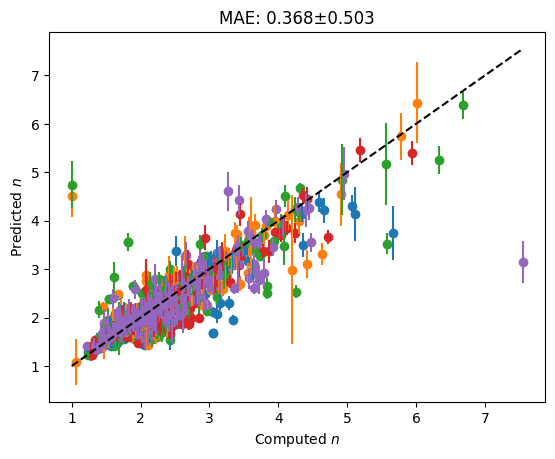

In [5]:
targets = ["refractive_index"]
experiment_name = "GA2_kfold_ensemble-" + "-".join(targets)
scores = []

for ind, (train, test) in enumerate(
    kf.split(md_naccarato_new.df_featurized, y=md_naccarato_new.df_targets)
):
    train_moddata, test_moddata = md_naccarato_new.split((train, test))
    model_path = (
        Path(".") / "models" / "fitgenetic_2" / f"{experiment_name}_{ind}.pkl"
    )
    print(model_path)
    if model_path.exists():
        model = EnsembleMODNetModel.load(model_path)

    else:
        ga = FitGenetic(train_moddata)
        model = ga.run(
            size_pop=20, # dflt
            num_generations=10, # dflt
            nested=0, # dflt = 5
            n_jobs=4,
            early_stopping=4, # dflt
            refit=0, # dflt = 5
            fast=False,
        )
        model.save(model_path)

    scores.append(model.evaluate(test_moddata))

    predictions, uncertainties = model.predict(test_moddata, return_unc=True)

    plt.scatter(
        test_moddata.df_targets.values.ravel(),
        predictions.values.ravel(),
    )
    plt.errorbar(
        test_moddata.df_targets.values.ravel(),
        predictions.values.ravel(),
        yerr=uncertainties.values.ravel(),
        ls="none",
    )

print("="*10 + f" {experiment_name} " + "="*10)
print("Training complete.")
print("Training complete.")
print(f"Accuracy: {np.mean(scores):.3f}±{np.std(scores):.3f}")

plt.plot(
    np.linspace(
        np.min(md_naccarato_new.df_targets.values),
        np.max(md_naccarato_new.df_targets.values),
        3,
    ),
    np.linspace(
        np.min(md_naccarato_new.df_targets.values),
        np.max(md_naccarato_new.df_targets.values),
        3,
    ),
    color="black",
    ls="--",
)

plt.ylabel("Predicted $n$")
plt.xlabel("Computed $n$")
# plt.xlim((-1,30))
# plt.ylim((-1,30))
plt.title(f"MAE: {np.mean(scores):.3f}±{np.std(scores):.3f}")
plt.savefig(Path(".") / "models" / "fitgenetic_2" / f"{experiment_name}.pdf")


models/fitgenetic_3/GA3_kfold_ensemble-refractive_index_0.pkl
2024-01-11 07:36:17,047 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f0bd78713a0> object, created with modnet version 0.4.1
26/26 [==============================] - 0s 791us/step
models/fitgenetic_3/GA3_kfold_ensemble-refractive_index_1.pkl
2024-01-11 07:36:27,839 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f0bd7c63760> object, created with modnet version 0.4.1
26/26 [==============================] - 0s 1ms/step
models/fitgenetic_3/GA3_kfold_ensemble-refractive_index_2.pkl
2024-01-11 07:36:39,167 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f0bd7bda820> object, created with modnet version 0.4.1
26/26 [==============================] - 0s 769us/step
models/fitgenetic_3/GA3_kfold_ensemble-refractive_index_3.pkl
2024-01-11 07:36:49,111 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7

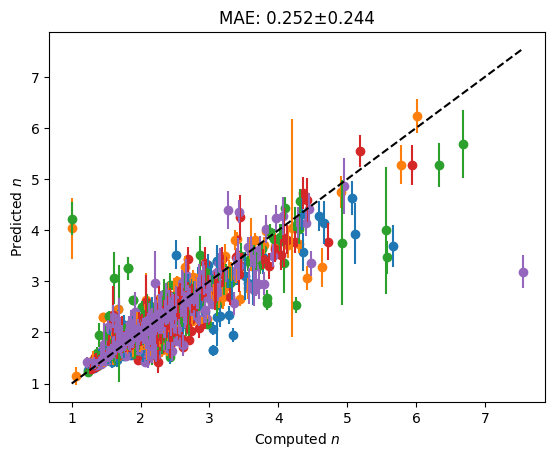

In [5]:
targets = ["refractive_index"]
experiment_name = "GA3_kfold_ensemble-" + "-".join(targets)
scores = []

for ind, (train, test) in enumerate(
    kf.split(md_naccarato_new.df_featurized, y=md_naccarato_new.df_targets)
):
    train_moddata, test_moddata = md_naccarato_new.split((train, test))
    model_path = (
        Path(".") / "models" / "fitgenetic_3" / f"{experiment_name}_{ind}.pkl"
    )
    print(model_path)
    if model_path.exists():
        model = EnsembleMODNetModel.load(model_path)

    else:
        ga = FitGenetic(train_moddata)
        model = ga.run(
            size_pop=20, # dflt
            num_generations=10, # dflt
            nested=5, # dflt = 5
            n_jobs=2,
            early_stopping=4, # dflt
            refit=0, # dflt = 5
            fast=False,
        )
        model.save(model_path)

    scores.append(model.evaluate(test_moddata))

    predictions, uncertainties = model.predict(test_moddata, return_unc=True)

    plt.scatter(
        test_moddata.df_targets.values.ravel(),
        predictions.values.ravel(),
    )
    plt.errorbar(
        test_moddata.df_targets.values.ravel(),
        predictions.values.ravel(),
        yerr=uncertainties.values.ravel(),
        ls="none",
    )

print("="*10 + f" {experiment_name} " + "="*10)
print("Training complete.")
print("Training complete.")
print(f"Accuracy: {np.mean(scores):.3f}±{np.std(scores):.3f}")

plt.plot(
    np.linspace(
        np.min(md_naccarato_new.df_targets.values),
        np.max(md_naccarato_new.df_targets.values),
        3,
    ),
    np.linspace(
        np.min(md_naccarato_new.df_targets.values),
        np.max(md_naccarato_new.df_targets.values),
        3,
    ),
    color="black",
    ls="--",
)

plt.ylabel("Predicted $n$")
plt.xlabel("Computed $n$")
plt.title(f"MAE: {np.mean(scores):.3f}±{np.std(scores):.3f}")
plt.savefig(Path(".") / "models" / "fitgenetic_3" / f"{experiment_name}.pdf")


# Production

## Training on the whole dataset

In [12]:
targets = ["refractive_index"]
experiment_name = "GA_Rf0_Nstd0-" + "-".join(targets)
scores = []

model_path = (
    Path(".") / "models" / "production" / f"{experiment_name}_prod_v1.pkl"
)

if model_path.exists():
    model = EnsembleMODNetModel.load(model_path)

else:
    ga = FitGenetic(md_naccarato_new)
    model = ga.run(
        size_pop=20, # dflt
        num_generations=10, # dflt
        nested=0, # dflt = 5
        n_jobs=4,
        early_stopping=4, # dflt
        refit=0, # dflt = 5
        fast=False,
    )
    model.save(model_path)

2024-01-09 09:04:51,778 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f5bc046d220> object, created with modnet version 0.4.1


In [29]:
targets = ["refractive_index"]
experiment_name = "GA_Rf0_Nstd5-" + "-".join(targets)
scores = []

model_path = (
    Path(".") / "models" / "production" / f"{experiment_name}_prod_v1.pkl"
)

if model_path.exists():
    model = EnsembleMODNetModel.load(model_path)

else:
    ga = FitGenetic(md_naccarato_new)
    model = ga.run(
        size_pop=20, # dflt
        num_generations=10, # dflt
        nested=5, # dflt = 5
        n_jobs=2,
        early_stopping=4, # dflt
        refit=0, # dflt = 5
        fast=False,
    )
    model.save(model_path)

2024-01-09 09:17:37,845 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7f5b10319940> object, created with modnet version 0.4.1


## Preparing the MP

In [45]:
print(df_outputs.shape)

(76, 5)


In [53]:
with open('../v0/df_mp_2023_feat_filtered.pkl', 'rb') as f:
    df_mp_2023_feat_filtered = pickle.load(f)
print(df_mp_2023_feat_filtered.shape)

# # Let's read the selected candidates of the v0 cycle to remove them from the still-to-predict MP
# df_selected_v0 = pd.read_json('../v0/df_selected_v0.json')
# # Should drop all of those but since I stopped the v0 computation by accident, let's retry those that did not finish

df_mp_2023_feat_filtered = df_mp_2023_feat_filtered.drop(index=df_outputs.index.values)
print(df_mp_2023_feat_filtered.shape)

(24186, 4565)
(24110, 4565)


In [54]:
# # Load MP 2023 structures, bandgap, ehull
path_structures_mp_2023 = (
    Path("./../../../") / "re2fractive_onedrive" / "data" / "mp2023_structures.json"
)
with open(path_structures_mp_2023, "r") as f:
    strucs_mp = json.load(f)

# Filter the MP docs to remove Naccarato's dataset and the materials with refractive index
strucs_mp_filt = [doc for doc in strucs_mp if doc["id"] in df_mp_2023_feat_filtered.index.values.flatten()]

# Reorder the MP docs to match the order of the filtered MP MODData 
strucs_mp_filt_odd = sorted(strucs_mp_filt, key=lambda x: list(df_mp_2023_feat_filtered.index.values.flatten()).index(x['id']))

print(len(strucs_mp_filt_odd))

24110


In [28]:
# # Recover a dataframe of Pymatgen Structures from the optimade docs
# from optimade.adapters import Structure as optim_Structure
# df_mp_structures = pd.DataFrame.from_dict(
#     {doc["id"]: {"structure": optim_Structure(doc).as_pymatgen} for doc in strucs_mp_filt_odd}, orient="index"
# )

# # Instantiate a MODData for the filtered MP
# md_mp_filt = MODData(
#     materials=df_mp_structures['structure'],
#     # targets=data.targets,
#     # target_names=["refractive_index"],
#     df_featurized = df_mp_2023_feat_filtered,
#     structure_ids=df_mp_2023_feat_filtered.index.values.flatten(),
# )
# md_mp_filt.save("mod.data_mp2023_filtered_v1")


# Load the prepared (filtered) MP MODData
md_mp_filt = MODData.load("mod.data_mp2023_filtered_v1")

2024-01-09 09:17:18,772 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7f5afc25dac0> object, created with modnet version 0.4.1


In [34]:
# # Predict the filtered MP
# results = model.predict(md_mp_filt, return_unc=True)


# with open('results_mp_v1.pkl', 'wb') as f:
#     pickle.dump(results, f)
with open('results_mp_v1.pkl', 'rb') as f:
    results = pickle.load(f)


# Recover the predictions and the associated uncertainties
predictions, uncertainties = results

## Vis. n-Eg

### Recover Naccarato dataset bandgap

In [48]:
# Load MP 2023 structures, bandgap, ehull
path_structures_naccarato = (
    Path("./../../../") / "re2fractive_onedrive" / "data" / "structures.json"
)
with open(path_structures_naccarato, "r") as f:
    strucs_naccarato = json.load(f)

### Vis.

In [52]:
import plotly.express as px
import plotly.graph_objects as go

# Data
gap_naccarato = [strucs_naccarato[mpid]["attributes"]["_naccarato_gga_bandgap"] for mpid in strucs_naccarato]
refractive_index_naccarato = [strucs_naccarato[mpid]["attributes"]["_naccarato_refractive_index"] for mpid in strucs_naccarato]
gap_mp = [struc['attributes']["_mp_band_gap"] for struc in strucs_mp_filt_odd]
refractive_index_mp_pred = predictions.refractive_index.values.flatten()
refractive_index_mp_unc = uncertainties.refractive_index.values.flatten()

data_naccarato = {'x': gap_naccarato, 'y': refractive_index_naccarato}
data_mp_pred = {'x': gap_mp, 'y': refractive_index_mp_pred, 'error_y': {'array': refractive_index_mp_unc, 'visible': True}}
data_outputs_filtout = {'x': df_outputs_filtout['bandgap'], 'y': df_outputs_filtout['refractive_index']}


# Scatter plot for Nacc.
scatter_naccarato = go.Scatter(
    x=data_naccarato['x'],
    y=data_naccarato['y'],
    mode='markers',
    marker=dict(symbol='x'),
    name='Nacc.'
)

# Scatter plot for the v0 outputs without the outliers.
scatter_outputs_filtout = go.Scatter(
    x=data_outputs_filtout['x'],
    y=data_outputs_filtout['y'],
    mode='markers',
    marker=dict(symbol='x'),
    name='Out. v0'
)

# Scatter plot for MP pred.
scatter_mp_pred = go.Scatter(
    x=data_mp_pred['x'],
    y=data_mp_pred['y'],
    mode='markers',
    error_y=data_mp_pred['error_y'],
    # marker='.',
    # line=dict(color='darkorange'),
    name='MP pred.',
    text=[struc["id"] for struc in strucs_mp_filt_odd]
)

# Layout
layout = go.Layout(
    title=dict(text='Scatter Plot'),
    xaxis=dict(title='$E_g$ (eV)', showgrid=True),
    yaxis=dict(title='$n$', showgrid=True),
    legend=dict(font=dict(size=12))
)

# Create figure
fig = go.Figure(data=[scatter_naccarato, scatter_outputs_filtout, scatter_mp_pred], layout=layout)

# Show figure
fig.show()

## Selection candidates

First let's put all the necessary information into one dataframe

In [55]:
ehull_mp_filt_odd = [struc['attributes']["_mp_energy_above_hull"] for struc in strucs_mp_filt_odd]
nsites_mp_filt_odd = [struc['attributes']["nsites"] for struc in strucs_mp_filt_odd]

In [56]:
predictions['nsites'] = nsites_mp_filt_odd
predictions['ehull'] = np.array(ehull_mp_filt_odd)
predictions['refractive_index_unc'] = uncertainties['refractive_index'].values
predictions['bandgap'] = gap_mp
predictions['structure'] = [struc.as_dict() for struc, mpid in zip(md_mp_filt.structures, md_mp_filt.structure_ids) if mpid in predictions.index]

Second let's remove the obvious outliers

In [57]:
outliers = ['mp-568145', 'mp-23155', 'mp-111', 'mp-754382', 'mp-23158', 'mp-23156', 'mp-614456']
predictions = predictions.drop(outliers, axis=0)

Third let's put all the necessary information into one dataframe

In [58]:
predictions['fom_energy'] = np.sqrt(predictions['bandgap'])*(predictions['refractive_index']+predictions['refractive_index_unc'])**2
predictions['fom_leak'] = predictions['bandgap']*(predictions['refractive_index']+predictions['refractive_index_unc'])**2

In [59]:
fom_energy_minmax = (predictions['fom_energy']-min(predictions['fom_energy']))/(max(predictions['fom_energy'])-min(predictions['fom_energy']))
fom_leak_minmax = (predictions['fom_leak']-min(predictions['fom_leak']))/(max(predictions['fom_leak'])-min(predictions['fom_leak']))

In [60]:
predictions['avg_fom'] = (fom_energy_minmax+fom_leak_minmax)/2

In [61]:
predictions = predictions[predictions['nsites']<80]
predictions = predictions[predictions['ehull']<0.025] # already satisfied to begin with
predictions

,refractive_index,nsites,ehull,refractive_index_unc,bandgap,structure,fom_energy,fom_leak,avg_fom
mp-10009,3.234794,8,0.000000,0.134700,0.7853,"{'@module': 'pymatgen.core.structure', '@class...",10.061144,8.915899,0.213928
mp-1001012,2.235738,14,0.009354,0.186687,0.5768,"{'@module': 'pymatgen.core.structure', '@class...",4.456696,3.384742,0.075874
mp-1001019,2.502804,14,0.003289,0.128160,1.0918,"{'@module': 'pymatgen.core.structure', '@class...",7.232718,7.557411,0.158839
mp-1001024,2.257167,14,0.003040,0.103362,1.7768,"{'@module': 'pymatgen.core.structure', '@class...",7.427421,9.900504,0.185527
mp-1001080,1.512386,12,0.004743,0.057971,5.6848,"{'@module': 'pymatgen.core.structure', '@class...",5.879694,14.018847,0.204863
...,...,...,...,...,...,...,...,...,...
mp-999471,2.581857,4,0.000000,0.302148,1.8121,"{'@module': 'pymatgen.core.structure', '@class...",11.196516,15.072107,0.293147
mp-999474,2.391669,4,0.000000,0.241846,1.8867,"{'@module': 'pymatgen.core.structure', '@class...",9.526276,13.085025,0.248557
mp-999488,2.382538,4,0.000000,0.237617,1.8635,"{'@module': 'pymatgen.core.structure', '@class...",9.371705,12.793322,0.243333
mp-999489,2.504057,4,0.000000,0.297884,1.3585,"{'@module': 'pymatgen.core.structure', '@class...",9.150565,10.665414,0.218450


In [62]:
pred_sorted = predictions.sort_values(by=['avg_fom'], ascending=False)

In [67]:
df_selected = pred_sorted.iloc[:200]
df_selected

,refractive_index,nsites,ehull,refractive_index_unc,bandgap,structure,fom_energy,fom_leak,avg_fom
mp-1028576,3.176621,12,0.018987,0.346616,4.0110,"{'@module': 'pymatgen.core.structure', '@class...",24.860508,49.789335,0.845821
mp-1028594,3.628989,12,0.012652,0.229720,2.9357,"{'@module': 'pymatgen.core.structure', '@class...",25.511727,43.711499,0.793463
mp-1030335,3.184843,12,0.012671,0.338990,3.1716,"{'@module': 'pymatgen.core.structure', '@class...",22.114126,39.383018,0.699844
mp-1187892,3.089004,9,0.000000,0.433639,2.5016,"{'@module': 'pymatgen.core.structure', '@class...",19.626654,31.042394,0.578668
mp-1187769,2.084278,3,0.002141,0.324009,6.2294,"{'@module': 'pymatgen.core.structure', '@class...",14.475696,36.129550,0.555299
...,...,...,...,...,...,...,...,...,...
mp-1202783,2.847992,60,0.000000,0.144277,2.1638,"{'@module': 'pymatgen.core.structure', '@class...",13.170734,19.373967,0.365730
mp-570339,2.732208,22,0.014185,0.149195,2.3902,"{'@module': 'pymatgen.core.structure', '@class...",12.835862,19.844592,0.365635
mp-27479,2.475108,52,0.000000,0.137473,3.0838,"{'@module': 'pymatgen.core.structure', '@class...",11.986231,21.048723,0.365495
mp-1198724,2.778628,42,0.000000,0.346203,1.9259,"{'@module': 'pymatgen.core.structure', '@class...",13.550962,18.805591,0.365492


In [68]:
# df_selected.to_json('df_selected_v1.json')
df_selected = pd.read_json('df_selected_v1.json')